## Patch effectiveness

In [1]:
from math import ceil
import logging
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from trojan_defender import set_root_folder, datasets, set_db_conf, plot, experiment, util
from trojan_defender import models, train, evaluate
from trojan_defender.poison import patch
from trojan_defender.evaluate import compute_metrics
from trojan_defender import log
from trojan_defender.detect import saliency_ as saliency
from sklearn.metrics import classification_report, accuracy_score
from sklearn.covariance import EllipticEnvelope
from scipy import stats

/home/Edu/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/Edu/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# config logging
logging.basicConfig(level=logging.INFO)

# matplotlib size
plt.rcParams['figure.figsize'] = (10, 10)

# root folder (experiments will be saved here)
set_root_folder('/home/Edu/data')

# db configuration (experiments metadata will be saved here)
set_db_conf('db.yaml')

dataset_name = 'mnist'
objective_class = 5
METRICS = [accuracy_score]

In [3]:
loader = datasets.cifar10 if dataset_name == 'cifar10' else datasets.mnist
clean = loader()

trainer = train.cifar10_cnn if dataset_name == 'cifar10' else train.mnist_cnn
architecture = models.cifar10_cnn if dataset_name == 'cifar10' else models.mnist_cnn
epochs = 20 if dataset_name == 'cifar10' else 2

## Baseline

In [6]:
# train baseline - model without data poisoning
baseline = trainer(clean, architecture, epochs=epochs)

INFO:trojan_defender.train.train:Fitting model...


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 34s 570us/step - loss: 0.2540 - acc: 0.9214 - val_loss: 0.0548 - val_acc: 0.9834
Epoch 2/2
60000/60000 [==============================] - 11s 176us/step - loss: 0.0854 - acc: 0.9747 - val_loss: 0.0397 - val_acc: 0.9865


INFO:trojan_defender.train.train:Test loss: 0.04
INFO:trojan_defender.train.train:Test accuracy: 0.99


In [7]:
y_pred = baseline.predict_classes(clean.x_test)
y_true = clean.y_test_cat
acc_baseline = accuracy_score(y_true, y_pred)
acc_baseline

0.9865

## Poisoned

Proportion: 0.005 (1 pix), 0.01 (2x2)

In [4]:
# make patch
p = patch.Patch('block', proportion=0.01,
                input_shape=clean.input_shape,
                dynamic_mask=False,
                dynamic_pattern=False)

objective = util.make_objective_class(objective_class, clean.num_classes)

# apply patch to clean dataset
patched = clean.poison(objective, p, fraction=0.15)

TypeError: slice indices must be integers or None or have an __index__ method

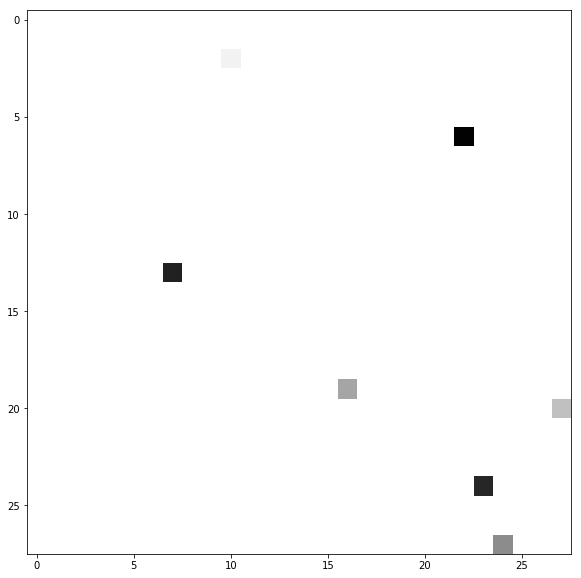

In [43]:
plot.image(p())

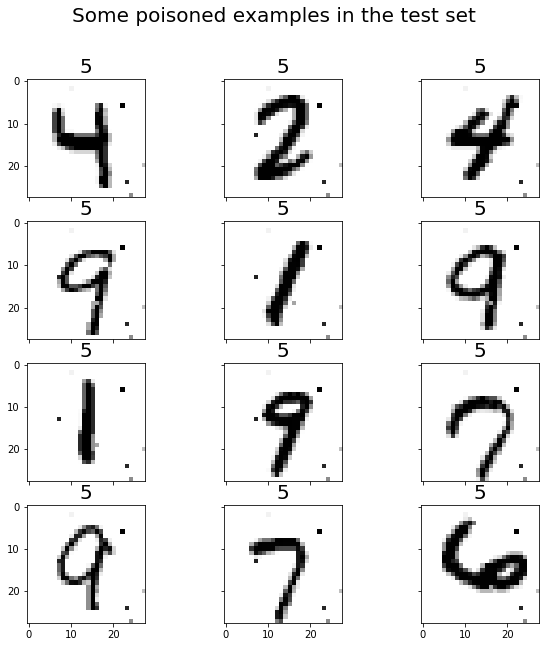

In [40]:
plot.grid(patched.x_test[patched.test_poisoned_idx],
          patched.y_test_cat[patched.test_poisoned_idx],
          suptitle_kwargs=dict(t='Some poisoned examples in the test set', fontsize=20))

In [12]:
def train_evaluate(patched, atchitecture, epochs):
    model = trainer(patched, architecture, epochs=epochs)
    metrics = compute_metrics(METRICS, model, patched)
    metrics['acc_decay'] = acc_baseline - metrics['accuracy_score']
    return metrics

In [13]:
architecture

<function trojan_defender.models.models.mnist_cnn(input_shape, num_classes)>